# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

### <span style='color:#ff5f27'> 0.📝 Imports

In [27]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [28]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 14, 17, 30, 483675)

## <span style='color:#ff5f27'> 1.Download 

### <span style="color:#ff5f27;"> 1.1📡 Connect to Hopsworks Feature Store </span>

In [29]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1150100
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;"> 1.2⚙️ Feature View Retrieval</span>


In [30]:
feature_view = fs.get_feature_view(
    name='air_quality_rolling_fv',
    version=1,
)


### <span style="color:#ff5f27;">1.3  Download the model from Model Registry</span>

In [31]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_rolling",
    version=2,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [32]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.596438E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">2. Inference: predict the future</span>



### <span style="color:#ff5f27;">2.0 Retrieve the weather predictions</span>

In [33]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,13.10,0.0,25.570139,234.743561,toscana
1,2024-11-22 00:00:00+00:00,13.55,0.0,24.066206,304.640991,toscana
2,2024-11-23 00:00:00+00:00,11.95,0.0,3.396233,122.005348,toscana
3,2024-11-24 00:00:00+00:00,14.75,0.0,4.680000,180.000000,toscana
4,2024-11-25 00:00:00+00:00,13.15,0.0,2.741678,336.801392,toscana
5,2024-11-26 00:00:00+00:00,18.25,0.0,11.165805,200.772339,toscana
6,2024-11-27 00:00:00+00:00,16.85,0.1,2.811690,309.805511,toscana
7,2024-11-28 00:00:00+00:00,15.45,0.0,1.938659,21.801476,toscana
8,2024-11-29 00:00:00+00:00,13.65,0.0,1.297998,326.309906,toscana


In [34]:
air_quality_roll_fg = fs.get_feature_group(
    name='air_quality_roll',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)


weather_df =weather_fg.read() 


air_quality_roll_df =air_quality_roll_fg.read() 
air_quality_roll_df = air_quality_roll_df.sort_values(by='date', ascending=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 


In [35]:
weather_df = weather_df.sort_values(by='date', ascending=False)
weather_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2887,2024-11-29 00:00:00+00:00,13.650000,0.0,1.297998,326.309906,toscana
2886,2024-11-28 00:00:00+00:00,15.450000,0.0,1.938659,21.801476,toscana
2885,2024-11-27 00:00:00+00:00,16.850000,0.1,2.811690,309.805511,toscana
2884,2024-11-26 00:00:00+00:00,18.250000,0.0,11.165805,200.772339,toscana
2883,2024-11-25 00:00:00+00:00,13.150000,0.0,2.741678,336.801392,toscana
...,...,...,...,...,...,...
2037,2017-01-07 00:00:00+00:00,-1.458417,0.0,12.229406,89.674461,toscana
2333,2017-01-06 00:00:00+00:00,-0.410500,0.0,21.900904,30.942194,toscana
703,2017-01-05 00:00:00+00:00,3.768667,1.9,26.368616,20.398815,toscana
2531,2017-01-04 00:00:00+00:00,5.160333,0.4,9.585739,180.353638,toscana


In [36]:
air_quality_roll_df

,date,pm25,country,city,street,url,pm25_rolling
2758,2024-11-20 00:00:00+00:00,78.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,78.000000
2757,2024-11-19 00:00:00+00:00,78.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,78.000000
2485,2024-11-18 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,83.666667
1304,2024-11-17 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,89.333333
1725,2024-11-16 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,95.000000
...,...,...,...,...,...,...,...
1984,2017-01-07 00:00:00+00:00,55.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,81.000000
377,2017-01-06 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,57.666667
946,2017-01-05 00:00:00+00:00,50.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,49.000000
728,2017-01-04 00:00:00+00:00,82.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,58.000000


In [37]:
# Ensure 'date' columns are in datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'])
air_quality_roll_df['date'] = pd.to_datetime(air_quality_roll_df['date'])

# Merge on 'city' and 'date'
merged_data = pd.merge(
    air_quality_roll_df[['city', 'date', 'pm25', 'pm25_rolling']],  # Select desired columns from air_quality_roll_df
    weather_df,  # Include all columns from weather_df
    on=['city', 'date'],  # Merge on both 'city' and 'date'
    how='inner'  # Use 'inner' to keep only matching rows
)

# Sort by 'date' in descending order
merged_data_past = merged_data.sort_values(by='date', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
merged_data_past


,city,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,toscana,2024-11-20 00:00:00+00:00,78.0,78.000000,16.250000,0.1,31.869658,256.277679
1,toscana,2024-11-19 00:00:00+00:00,78.0,78.000000,15.200000,0.3,17.377226,230.042511
2,toscana,2024-11-18 00:00:00+00:00,95.0,83.666667,16.400000,0.2,4.104631,164.744827
3,toscana,2024-11-17 00:00:00+00:00,95.0,89.333333,14.550000,0.1,10.805998,209.981552
4,toscana,2024-11-16 00:00:00+00:00,95.0,95.000000,7.208250,0.0,9.290511,152.250320
...,...,...,...,...,...,...,...,...
2754,toscana,2017-01-07 00:00:00+00:00,55.0,81.000000,-1.458417,0.0,12.229406,89.674461
2755,toscana,2017-01-06 00:00:00+00:00,42.0,57.666667,-0.410500,0.0,21.900904,30.942194
2756,toscana,2017-01-05 00:00:00+00:00,50.0,49.000000,3.768667,1.9,26.368616,20.398815
2757,toscana,2017-01-04 00:00:00+00:00,82.0,58.000000,5.160333,0.4,9.585739,180.353638


In [38]:
batch_data['date'] = pd.to_datetime(batch_data['date'])
air_quality_roll_df['date'] = pd.to_datetime(air_quality_roll_df['date'])

# Merge on 'date' column
merged_data = pd.merge(
    batch_data,
    air_quality_roll_df[['date', 'pm25', 'pm25_rolling']],
    on='date',
    how='left'  # Use 'left' to keep all rows in batch_data
)

# Check the resulting DataFrame
merged_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,pm25_rolling
0,2024-11-21 00:00:00+00:00,13.10,0.0,25.570139,234.743561,toscana,NaN,NaN
1,2024-11-22 00:00:00+00:00,13.55,0.0,24.066206,304.640991,toscana,NaN,NaN
2,2024-11-23 00:00:00+00:00,11.95,0.0,3.396233,122.005348,toscana,NaN,NaN
3,2024-11-24 00:00:00+00:00,14.75,0.0,4.680000,180.000000,toscana,NaN,NaN
4,2024-11-25 00:00:00+00:00,13.15,0.0,2.741678,336.801392,toscana,NaN,NaN
5,2024-11-26 00:00:00+00:00,18.25,0.0,11.165805,200.772339,toscana,NaN,NaN
6,2024-11-27 00:00:00+00:00,16.85,0.1,2.811690,309.805511,toscana,NaN,NaN
7,2024-11-28 00:00:00+00:00,15.45,0.0,1.938659,21.801476,toscana,NaN,NaN
8,2024-11-29 00:00:00+00:00,13.65,0.0,1.297998,326.309906,toscana,NaN,NaN


In [39]:
last_three_past_data = merged_data_past.tail(3)
last_three_past_data


stacked_data = pd.concat([last_three_past_data, merged_data], ignore_index=True)
stacked_data

,city,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,toscana,2017-01-05 00:00:00+00:00,50.0,49.0,3.768667,1.9,26.368616,20.398815
1,toscana,2017-01-04 00:00:00+00:00,82.0,58.0,5.160333,0.4,9.585739,180.353638
2,toscana,2017-01-03 00:00:00+00:00,42.0,58.0,6.456165,21.0,23.784531,48.117687
3,toscana,2024-11-21 00:00:00+00:00,NaN,NaN,13.100000,0.0,25.570139,234.743561
4,toscana,2024-11-22 00:00:00+00:00,NaN,NaN,13.550000,0.0,24.066206,304.640991
5,toscana,2024-11-23 00:00:00+00:00,NaN,NaN,11.950000,0.0,3.396233,122.005348
6,toscana,2024-11-24 00:00:00+00:00,NaN,NaN,14.750000,0.0,4.680000,180.000000
7,toscana,2024-11-25 00:00:00+00:00,NaN,NaN,13.150000,0.0,2.741678,336.801392
8,toscana,2024-11-26 00:00:00+00:00,NaN,NaN,18.250000,0.0,11.165805,200.772339
9,toscana,2024-11-27 00:00:00+00:00,NaN,NaN,16.850000,0.1,2.811690,309.805511


### <span style="color:#ff5f27;">2.1 Making the predictions</span>

In [40]:
# Step 1: Ensure the first two rows are untouched
stacked_data['pm25_rolling'] = None  # Clear existing rolling values
stacked_data.loc[:1, 'pm25_rolling'] = stacked_data.loc[:1, 'pm25_rolling']

# Step 2: Define features used for prediction
features = ['temperature_2m_mean', 'pm25_rolling', 'precipitation_sum', 
            'wind_speed_10m_max', 'wind_direction_10m_dominant']

# Step 3: Iterate through each row starting from the 3rd row (index 2)
for idx in range(2, len(stacked_data)):
    # For the first prediction (idx=2), use the last known rolling average
    if idx == 2:
        stacked_data.loc[idx, 'pm25_rolling'] = stacked_data.loc[1, 'pm25_rolling']
    
    # Prepare the row for prediction
    row_to_predict = stacked_data.iloc[idx]
    
    # Prepare input for the model
    X = row_to_predict[features].values.reshape(1, -1)
    
    # Predict pm25 for the current row
    predicted_pm25 = retrieved_xgboost_model.predict(X)[0]
    
    # Update the pm25 value for the current row
    stacked_data.loc[idx, 'pm25'] = predicted_pm25
    
    # Calculate rolling average for the next row
    if idx < len(stacked_data) - 1:  # If not the last row
        # Get the last 3 PM2.5 values (including the one we just predicted)
        last_three_pm25 = stacked_data['pm25'].iloc[max(0, idx-1):idx+1]
        # Calculate and set the rolling average for the next row
        stacked_data.loc[idx + 1, 'pm25_rolling'] = last_three_pm25.mean()

# Display the updated DataFrame
stacked_data.drop(['city'], axis=1, inplace=True)
stacked_data

,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-01-05 00:00:00+00:00,50.000000,None,3.768667,1.9,26.368616,20.398815
1,2017-01-04 00:00:00+00:00,82.000000,None,5.160333,0.4,9.585739,180.353638
2,2017-01-03 00:00:00+00:00,30.210155,None,6.456165,21.0,23.784531,48.117687
3,2024-11-21 00:00:00+00:00,26.542772,56.10508,13.100000,0.0,25.570139,234.743561
4,2024-11-22 00:00:00+00:00,27.314047,28.376465,13.550000,0.0,24.066206,304.640991
5,2024-11-23 00:00:00+00:00,33.267567,26.92841,11.950000,0.0,3.396233,122.005348
6,2024-11-24 00:00:00+00:00,28.777645,30.290806,14.750000,0.0,4.680000,180.000000
7,2024-11-25 00:00:00+00:00,28.924215,31.022606,13.150000,0.0,2.741678,336.801392
8,2024-11-26 00:00:00+00:00,19.029144,28.850929,18.250000,0.0,11.165805,200.772339
9,2024-11-27 00:00:00+00:00,29.477995,23.976681,16.850000,0.1,2.811690,309.805511


### <span style="color:#ff5f27;">2.2 Saving the predictions (for monitoring) to a Feature Group</span>

In [41]:
batch_data = stacked_data.iloc[3:]
batch_data = batch_data[['date','temperature_2m_mean','wind_speed_10m_max','wind_direction_10m_dominant','pm25',]].rename(columns={'pm25': 'predicted_pm25'})
batch_data

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
3,2024-11-21 00:00:00+00:00,13.10,25.570139,234.743561,26.542772
4,2024-11-22 00:00:00+00:00,13.55,24.066206,304.640991,27.314047
5,2024-11-23 00:00:00+00:00,11.95,3.396233,122.005348,33.267567
6,2024-11-24 00:00:00+00:00,14.75,4.680000,180.000000,28.777645
7,2024-11-25 00:00:00+00:00,13.15,2.741678,336.801392,28.924215
8,2024-11-26 00:00:00+00:00,18.25,11.165805,200.772339,19.029144
9,2024-11-27 00:00:00+00:00,16.85,2.811690,309.805511,29.477995
10,2024-11-28 00:00:00+00:00,15.45,1.938659,21.801476,33.096043
11,2024-11-29 00:00:00+00:00,13.65,1.297998,326.309906,28.924215


In [42]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
3,2024-11-21 00:00:00+00:00,13.10,25.570139,234.743561,26.542772,pisa,toscana,italy,1
4,2024-11-22 00:00:00+00:00,13.55,24.066206,304.640991,27.314047,pisa,toscana,italy,2
5,2024-11-23 00:00:00+00:00,11.95,3.396233,122.005348,33.267567,pisa,toscana,italy,3
6,2024-11-24 00:00:00+00:00,14.75,4.680000,180.000000,28.777645,pisa,toscana,italy,4
7,2024-11-25 00:00:00+00:00,13.15,2.741678,336.801392,28.924215,pisa,toscana,italy,5
8,2024-11-26 00:00:00+00:00,18.25,11.165805,200.772339,19.029144,pisa,toscana,italy,6
9,2024-11-27 00:00:00+00:00,16.85,2.811690,309.805511,29.477995,pisa,toscana,italy,7
10,2024-11-28 00:00:00+00:00,15.45,1.938659,21.801476,33.096043,pisa,toscana,italy,8
11,2024-11-29 00:00:00+00:00,13.65,1.297998,326.309906,28.924215,pisa,toscana,italy,9


In [43]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 3 to 11
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   wind_speed_10m_max           9 non-null      float32            
 3   wind_direction_10m_dominant  9 non-null      float32            
 4   predicted_pm25               9 non-null      float32            
 5   street                       9 non-null      object             
 6   city                         9 non-null      object             
 7   country                      9 non-null      object             
 8   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(4), int64(1), object(3)
memory usage: 636.0+ bytes


### <span style="color:#ff5f27;">2.3 Create Forecast graph</span>

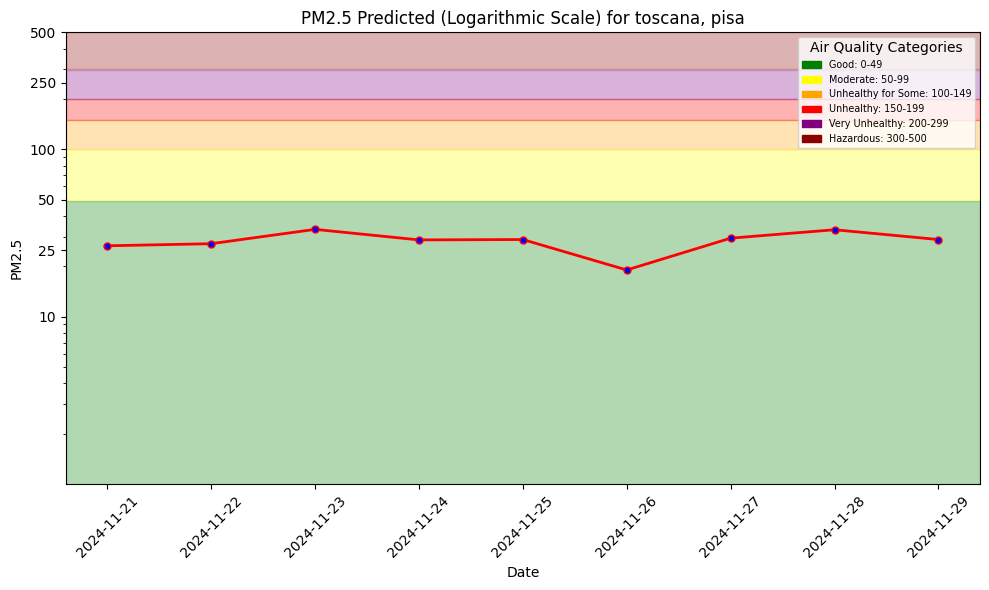

In [44]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

### <span style="color:#ff5f27;">2.4 Create Forecast FeatureGroup</span>

We do this part because we want to retrieve afterwards what's our prediction was during the week.

In [47]:
monitor_rolling_fg = fs.get_or_create_feature_group(
    name='aq_predictions_rollings',
    description='Air Quality prediction monitoring Rolling',
    version=1,
    primary_key=['date', 'days_before_forecast_day'],  # Set the primary keys
    event_time="date"  # Set the event time column
)

In [ ]:
monitor_rolling_fg.insert(batch_data, write_options={"wait_for_job": True})


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1150100/fs/1140803/fg/1359185


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_rollings_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1150100/jobs/named/aq_predictions_rollings_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1f5a5e38340>, None)

In [50]:
df = monitor_rolling_fg.read()
df.drop(['country','street','city'], axis = 1, inplace= True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


In [52]:
df

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,days_before_forecast_day
0,2024-11-22 00:00:00+00:00,13.55,24.066206,304.640991,27.314047,2
1,2024-11-24 00:00:00+00:00,14.75,4.680000,180.000000,28.777645,4
2,2024-11-23 00:00:00+00:00,11.95,3.396233,122.005348,33.267567,3
3,2024-11-26 00:00:00+00:00,18.25,11.165805,200.772339,19.029144,6
4,2024-11-25 00:00:00+00:00,13.15,2.741678,336.801392,28.924215,5
5,2024-11-27 00:00:00+00:00,16.85,2.811690,309.805511,29.477995,7
6,2024-11-29 00:00:00+00:00,13.65,1.297998,326.309906,28.924215,9
7,2024-11-21 00:00:00+00:00,13.10,25.570139,234.743561,26.542772,1
8,2024-11-28 00:00:00+00:00,15.45,1.938659,21.801476,33.096043,8


In [54]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_rolling_fg.filter(monitor_rolling_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,13.1,25.570139,234.743561,26.542772,pisa,toscana,italy,1


In [55]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df.tail()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,pm25,country,city,street,url
2754,2024-11-15 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2755,2024-11-17 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2756,2024-11-16 00:00:00+00:00,95.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2757,2024-11-19 00:00:00+00:00,78.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2758,2024-11-20 00:00:00+00:00,78.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432


#### Merging the data

In [58]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
#    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
#hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


ValueError: feature_names mismatch: ['pm25_rolling', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_rolling in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---